# Analyse in Datenbanken
Dieses Notebook zeigt anhand eines kurzen Beispiels, dass nicht immer Python und umfangreiche Bibliotheken für Analysen notwendig sind. Moderne Datenbanksysteme haben eine Vielzahl von integrierten Funktionen, die sowohl das Laden und Speichern von Dateien, aber auch statistische Berechnungen ermöglichen.

In [ ]:
%CREATE :memory:
%MAX_ROWS 10

## Inhaltsverzeichnis
- [Datensatz](#Datensatz)
- [Vorverarbeitung](#Vorverarbeitung)
- [Aggregation](#Aggregation)
- [Visualisierung](#Visualisierung)
- [Zusammenfassung](#Zusammenfassung)

## Datensatz
Die Wiener Sportstätten haben [auf ihrer Website](https://www.wienersportstaetten.at/home/stadthallenbad/oeffnungszeiten) einen Besucherzähler für das Stadthallenbad eingebaut. Dieser wird während der Badezeiten in Form eines Livestreams auf Twitch veröffentlicht.

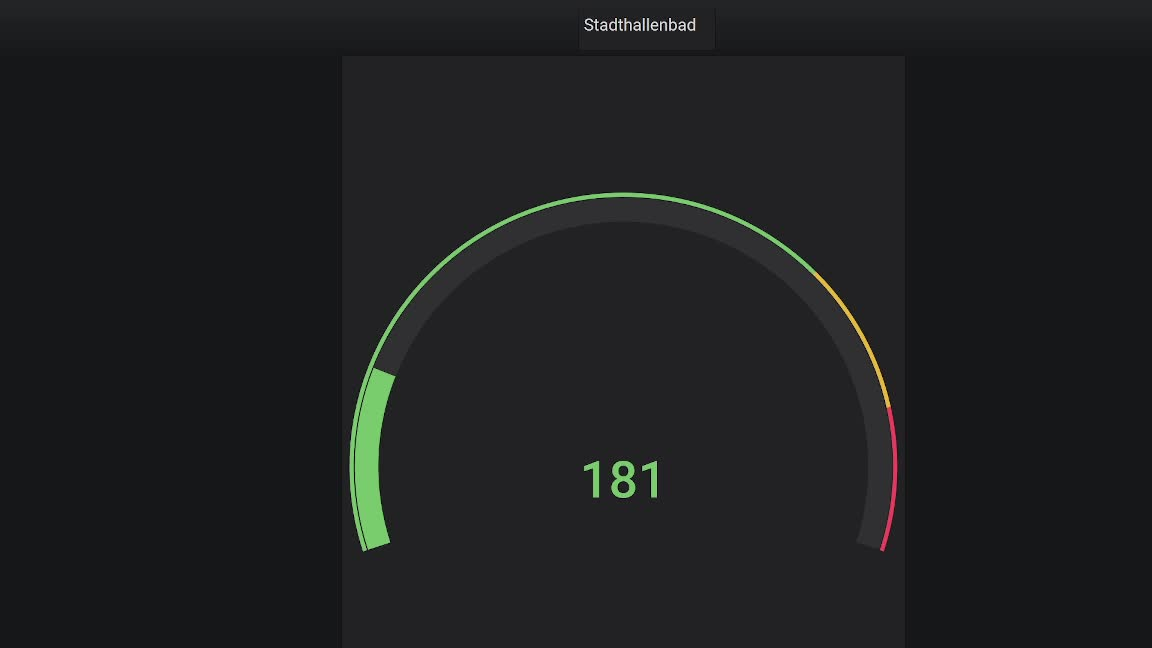

Das mitgelieferte [script.sh](script.sh) lädt ein Standbild aus dem Stream und wendet einige Vorverarbeitungsschritte an:

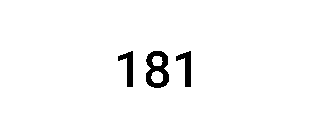

Die Anzahl wird dann mit Hilfe einer Texterkennung in einer CSV Datei im Format `Timestamp,Anzahl` protokolliert. Nachfolgend wollen wir diese Datei mit dem OLAP-Datenbanksystem [DuckDB](https://duckdb.org/) verarbeiten.

DuckDB besitzt zum Lesen von CSV Dateien eine [eigene Erweiterung](https://duckdb.org/docs/stable/data/csv/overview.html) `read_csv`. Die nachfolgende Zelle erstellt eine Sicht basierend auf dieser Funktion.

In [ ]:
CREATE OR REPLACE VIEW data (ts, day_of_week, minute_of_day, people) AS (
    SELECT
        ts,
        EXTRACT(ISODOW FROM ts),
        EXTRACT(HOUR FROM ts) * 60 + EXTRACT(MINUTE FROM ts),
        people
    FROM
        read_csv(
            'stadthallenbad_wien.csv',
            delim=',',
            header=false,
            auto_detect=false,
            columns = {
                'ts':     TIMESTAMP,
                'people': INTEGER
            },
            timestampformat='%Y-%m-%d_%H-%M-%S'
        )
)

In [ ]:
FROM data
ORDER BY ts

Bei einer Abfrage dieser Sicht wird tatsächlich aus der CSV Datei gelesen. Sie können das überprüfen, indem Sie eine Zeile in der Datei ändern und nur die Abfrage der Sicht erneut ausführen.

## Vorverarbeitung
Um eine sinnvolle Darstellung zu ermöglichen, erzeugen wir 30-minütige Slots während der Öffnungszeiten.

In [ ]:
CREATE OR REPLACE VIEW days (num, name) AS (
    VALUES
        (1, 'Montag'), (2, 'Dienstag'), (3, 'Mittwoch'), (4, 'Donnerstag'),
        (5, 'Freitag'), (6, 'Samstag'), (7, 'Sonntag')
)

In [ ]:
CREATE OR REPLACE VIEW times (minute_of_day) AS (
    WITH RECURSIVE t (minute) AS (
        SELECT 0

        UNION ALL

        SELECT minute + 30
        FROM   t
        WHERE  minute < 24 * 60
    )

    FROM  t
    WHERE EXISTS (
        FROM  data
        WHERE ABS(EXTRACT(HOUR FROM ts) * 60 + EXTRACT(MINUTE FROM ts) - t.minute) BETWEEN -15 AND 14
    )
)

In [ ]:
CREATE OR REPLACE VIEW slots (day_of_week, day_name, minute_of_day, slot_name) AS (
    SELECT *, printf('%02d:%02d', CAST(FLOOR(minute_of_day / 60) AS INTEGER), minute_of_day % 60)
    FROM   days, times
)

In [ ]:
FROM slots
ORDER BY day_of_week, minute_of_day

Jeder Eintrag wird nun dem Slot zugeordnet, der die geringste Distanz zum eigenen Zeitstempel besitzt. Dem Slot um 17:00 sollen also alle Einträge zugeordnet werden, die zwischen 16:45 (einschließlich) und 17:15 (ausschließlich) aufgenommen wurden. Ein `LEFT JOIN` wird verwendet, damit keine Slots verlorengehen.

In [ ]:
CREATE OR REPLACE VIEW data_in_slots (day_of_week, day_name, slot_name, ts, people) AS (
    SELECT    slots.day_of_week, day_name, slot_name, ts, people
    FROM      slots
    LEFT JOIN data
    ON        slots.day_of_week = data.day_of_week AND ABS(slots.minute_of_day - data.minute_of_day) BETWEEN -15 AND 14
)

In [ ]:
FROM data_in_slots
ORDER BY day_of_week, slot_name, ts

## Aggregation
Um die Daten zu aggregieren, wird der Median für jeden Slot berechnet.

In [ ]:
CREATE OR REPLACE VIEW median_per_slot (day_of_week, day_name, slot, people) AS (
    SELECT   day_of_week, day_name, slot_name, CAST(MEDIAN(people) AS INTEGER)
    FROM     data_in_slots
    GROUP BY day_of_week, day_name, slot_name
)

In [ ]:
FROM median_per_slot
ORDER BY day_of_week, slot

## Visualisierung
Um die Daten darzustellen, wird [Plotly](https://plotly.com/javascript/) verwendet. Dazu muss ein JSON-Objekt generiert werden, das von der JavaScript Bibliothek dargestellt werden kann. Glücklicherweise besitzt DuckDB auch die Fähigkeit, JSON-Objekte und -Listen zu verwalten.

In [ ]:
%PLOTLY_RAW TITLE Auslastung
SELECT
    array_to_json(LIST(json_object(
        'mode', 'lines+markers',
        'hovertemplate', day_name || ', %{x} Uhr<br>%{y} Gäste<extra></extra>',
        'name', day_name,
        'x', x,
        'y', y
    ) ORDER BY day_of_week)) AS json
FROM (
    SELECT
        day_of_week, day_name,
        LIST(slot ORDER BY slot) AS x,
        LIST(people ORDER BY slot) AS y
    FROM median_per_slot
    GROUP BY day_of_week, day_name
)

Mit einer weiteren Schachtelung der Anfragen lassen sich auch noch komplexere Diagrammtypen erzeugen.

In [ ]:
%PLOTLY_RAW TITLE Auslastung
SELECT
    json_array(json_object(
        'type', 'heatmap',
        'hoverongaps', false,
        'hovertemplate', '%{y}, %{x} Uhr<br>%{z} Gäste<extra></extra>',
        'x', x.x,
        'y', y.y,
        'z', z.z
    )) AS json
FROM
    (
        SELECT LIST(DISTINCT slot ORDER BY slot) AS x
        FROM   median_per_slot
    ) x,
    (
        SELECT LIST(name ORDER BY num DESC) AS y
        FROM   days
    ) y,
    (
        SELECT LIST(people_per_day_of_week ORDER BY day_of_week DESC) AS z
        FROM   (
            SELECT   day_of_week, LIST(people ORDER BY slot) AS people_per_day_of_week
            FROM     median_per_slot
            GROUP BY day_of_week
        )
    ) z

## Zusammenfassung
Viele Operationen lassen sch direkt innerhalb von Datenbanksystemen durchführen, sodass eine Datenübertragung vom Datenbankserver und ein Wechsel der Programmierumgebung entfällt. Andererseits müssen die gewünschte Funktionalität in SQL oder zumindest in UDFs ausdrückbar sein, wobei auf Analyse ausgerichtete Systeme bereits viele Funktionen mitbringen.